In [1]:
from IPython.display import Image

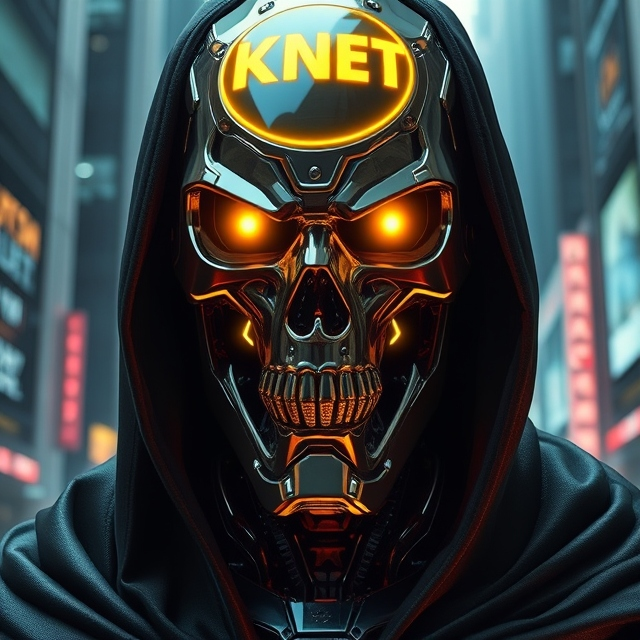

In [2]:
Image(filename = 'KNET.jpeg')

# KNET

#### KNET is an educational Retrieval-Augmented Generation (RAG) system built from scratch, designed to empower STEM learners by combining transformers and intelligent retrieval to simulate human reasoning and deliver precise, context-aware answers to foster curiosity and understanding!

#### Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Imports

In [3]:
import math
import torch
import torch.nn as nn

## 1. Define the Positioning Encoding Model

### Transformers rely on positional encoding to retain the order of the sequence data.

In [4]:
class PositionalEncoding(nn.Module):
    """
    Implements positional encoding for transformer models.

    This module injects information about the relative or absolute position
    of tokens in the sequence. the positional encodings have the same dimension
    as the embeddings so that the two can be summed.

    Attributes:
        dropout (nn.Dropout): dropout layer.
        pe (torch.Tensor): positional encoding matrix.
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): the dimensionality of embeddings.
            dropout (float): dropout rate. default is 0.1.
            max_len (int): maximum length of input sequences. default is 5000.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        self.pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)

    def forward(self, x):
        """
        Adds positional encoding to the input tensor.

        Args:
            x (torch.Tensor): input tensor of shape (seq_len, batch_size, d_model).

        Returns:
            torch.Tensor: tensor with positional encoding added.
        """
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

## 2. Define the Transformer Model

### This model includes an embedding layer, positional encoding, and the transformer itself.

In [5]:
class TransformerModel(nn.Module):
    """
    Defines a transformer-based sequence-to-sequence model.

    This model uses an encoder-decoder architecture with positional encoding
    and transformer layers to process sequences.

    Attributes:
        embedding (nn.Embedding): embedding layer for tokens.
        pos_encoder (PositionalEncoding): positional encoding module.
        transformer (nn.Transformer): transformer module.
        fc_out (nn.Linear): linear layer for output generation.
        d_model (int): dimensionality of the model's embeddings.
    """

    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        """
        Initializes the TransformerModel.

        Args:
            vocab_size (int): size of the vocabulary.
            d_model (int): dimensionality of embeddings. default is 128.
            nhead (int): number of attention heads. default is 4.
            num_layers (int): number of encoder and decoder layers. default is 2.
            dropout (float): dropout rate. default is 0.1.
        """
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None, tgt_mask=None):
        """
        Performs a forward pass through the transformer model.

        Args:
            src (torch.Tensor): source tensor of shape (seq_len_src, batch_size).
            tgt (torch.Tensor): target tensor of shape (seq_len_tgt, batch_size).
            src_padding_mask (torch.Tensor): source padding mask.
            tgt_padding_mask (torch.Tensor): target padding mask.
            tgt_mask (torch.Tensor): target mask to prevent attention to future tokens.

        Returns:
            torch.Tensor: output tensor of shape (seq_len_tgt, batch_size, vocab_size).
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)

        output = self.transformer(
            src,
            tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
        )
        output = self.fc_out(output)
        return output

## 3. Prepare the Corpus and Vocabulary

### We create a sample corpus and build a vocabulary from it.

In [6]:
def tokenize(text):
    """
    Tokenizes a given text into individual words.

    This function converts the input text to lowercase
    and splits it into words based on spaces.

    Args:
        text (str): the input string to be tokenized.

    Returns:
        list: a list of words (tokens) from the input text.
    """
    return text.lower().split()


# define the corpus with query and document labels
corpus_with_labels = [
    ("What is reverse engineering?", "Reverse engineering is the process of analyzing a system to identify its components and their interrelationships."),
    ("What is disassembly?", "Disassembly is the process of converting machine code into human-readable assembly code."),
    ("What is static analysis?", "Static analysis is the examination of software without executing it to understand its structure and behavior."),
    ("What is dynamic analysis?", "Dynamic analysis is the process of analyzing software while it is running to study its behavior."),
    ("What is a debugger?", "A debugger is a tool used to test and debug programs by allowing inspection of memory, registers, and instructions during execution."),
    ("What is IDA Pro?", "IDA Pro is a popular reverse engineering tool that provides a disassembler and decompiler for analyzing binary files."),
    ("What is Ghidra?", "Ghidra is an open-source reverse engineering tool developed by the NSA, featuring a powerful decompiler."),
    ("What is a control flow graph?", "A control flow graph is a representation of all possible paths that can be taken through a program during its execution."),
    ("What is malware analysis?", "Malware analysis is the process of studying malicious software to understand its behavior and mitigate threats."),
    ("What is obfuscation?", "Obfuscation is a technique used to make code harder to understand, often to protect intellectual property or evade detection."),
]


def build_vocab(corpus_with_labels):
    """
    Builds a vocabulary from the corpus by tokenizing all queries and documents.

    Args:
        corpus_with_labels (list of tuples): list of query-document pairs.

    Returns:
        dict: word-to-index mapping.
        dict: index-to-word mapping.
    """
    vocab = set()
    for query, doc in corpus_with_labels:
        vocab.update(tokenize(query))
        vocab.update(tokenize(doc))

    vocab = sorted(vocab)
    word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}
    word2idx['<unk>'] = 0  # unknown token
    word2idx['<pad>'] = len(word2idx)  # padding token
    word2idx['<sos>'] = len(word2idx)  # start of sequence
    word2idx['<eos>'] = len(word2idx)  # end of sequence
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word


# build vocabulary
word2idx, idx2word = build_vocab(corpus_with_labels)
vocab_size = len(word2idx)

## 4. Vectorize the Documents

### Convert each document into a vector using the vocabulary.

In [7]:
def vectorize(text, word2idx, vocab_size):
    """
    Converts a text document into a vector representation.

    This function tokenizes the input text and creates a vector
    where each index corresponds to a word in the vocabulary,
    and the value at that index is the frequency of the word in the text.

    Args:
        text (str): the input document to be vectorized.
        word2idx (dict): mapping of words to indices in the vocabulary.
        vocab_size (int): size of the vocabulary.

    Returns:
        torch.Tensor: a tensor representing the frequency of words in the document.
    """
    vec = torch.zeros(vocab_size)
    tokens = tokenize(text)
    for token in tokens:
        idx = word2idx.get(token, word2idx['<unk>'])
        vec[idx] += 1
    return vec


# create document vectors for the retriever
doc_vectors = [vectorize(doc, word2idx, vocab_size) for _, doc in corpus_with_labels]

## 5. Implement the Retriever

### Retrieve the top k documents most similar to the query.

In [8]:
def retrieve(query, doc_vectors, corpus, word2idx, vocab_size, top_k=2):
    """
    Retrieves the top-k most similar documents to the query based on cosine similarity.

    Args:
        query (str): the input query text.
        doc_vectors (list of torch.Tensor): a list of document vectors representing the corpus.
        corpus (list of tuples): the corpus of query-document pairs.
        word2idx (dict): mapping of words to indices in the vocabulary.
        vocab_size (int): size of the vocabulary.
        top_k (int): the number of most similar documents to retrieve. default is 2.

    Returns:
        list of str: the top-k most similar documents from the corpus.
    """
    query_vec = vectorize(query, word2idx, vocab_size)
    similarities = []
    for idx, doc_vec in enumerate(doc_vectors):
        sim = torch.dot(query_vec, doc_vec) / (
            torch.norm(query_vec) * torch.norm(doc_vec) + 1e-8
        )
        similarities.append((sim.item(), idx))
    similarities.sort(reverse=True)
    top_docs = [corpus[idx][1] for (_, idx) in similarities[:top_k]]
    return top_docs

## 6. Simulate Chain of Thought

### Create a function to simulate the reasoning process.

In [9]:
def generate_answer_with_chain_of_thought(query, retrieved_docs):
    """
    Simulates a reasoning process to generate an answer using a chain of thought.

    This function prints the logical steps involved in reasoning through
    the query and the retrieved documents, then formulates and outputs a simulated answer.

    Args:
        query (str): the input query text.
        retrieved_docs (list of str): a list of documents retrieved for the query.

    Returns:
        None
    """
    print('Chain of Thought:')
    reasoning_steps = [
        f"1. the query is: '{query}'",
        '2. retrieved the following documents:',
    ]
    for idx, doc in enumerate(retrieved_docs):
        reasoning_steps.append(f'   {idx + 1}. {doc}')
    reasoning_steps.append('3. analyzing the retrieved documents to answer the query.')
    reasoning_steps.append('4. formulating the answer based on the information.')
    for step in reasoning_steps:
        print(step)

## 7. Initialize the Transformer Model

### Instantiate the transformer model with the vocabulary size.

In [10]:
# initialize the transformer model with updated parameters
transformer_model = TransformerModel(vocab_size=vocab_size, d_model=128, nhead=4, num_layers=2, dropout=0.1)

/opt/anaconda3/envs/prod/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 8. Create the RAG System

### Combine the retriever and the generator (transformer model).

In [11]:
def rag_system(query, transformer_model, retriever, doc_vectors, corpus, word2idx, idx2word, vocab_size):
    """
    Implements a basic Retrieval-Augmented Generation (RAG) system.

    This function retrieves relevant documents for a query using the retriever,
    prepares the input for the transformer model by combining the query and retrieved documents,
    and generates an output using the transformer model.

    Args:
        query (str): the input query text.
        transformer_model (nn.Module): the transformer model for generating output.
        retriever (function): the document retrieval function.
        doc_vectors (list of torch.Tensor): a list of document vectors representing the corpus.
        corpus (list of tuples): the corpus of query-document pairs.
        word2idx (dict): mapping of words to indices in the vocabulary.
        idx2word (dict): mapping of indices to words in the vocabulary.
        vocab_size (int): size of the vocabulary.

    Returns:
        None
    """
    # retrieve relevant documents
    retrieved_docs = retriever(query, doc_vectors, corpus, word2idx, vocab_size)

    # prepare input by concatenating the query and retrieved documents
    input_text = query + ' ' + ' '.join(retrieved_docs)
    print('Input to the transformer model:')
    print(input_text)

    # tokenize and convert input to indices
    tokens = tokenize(input_text)
    input_indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    input_tensor = torch.tensor(input_indices).unsqueeze(1)  # add batch dimension

    # initialize decoder input with <sos>
    tgt_input = torch.tensor([word2idx['<sos>']]).unsqueeze(1)

    # generate output tokens iteratively
    transformer_model.eval()
    with torch.no_grad():
        for _ in range(50):  # maximum answer length
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input.size(0)).to(input_tensor.device)
            src_padding_mask = (input_tensor.squeeze(1) == word2idx['<pad>']).unsqueeze(0)
            tgt_padding_mask = (tgt_input.squeeze(1) == word2idx['<pad>']).unsqueeze(0)

            output = transformer_model(
                input_tensor,
                tgt_input,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask,
                tgt_mask=tgt_mask,
            )
            next_token = output.argmax(dim=-1)[-1, :].item()
            tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]])], dim=0)
            if next_token == word2idx['<eos>']:
                break

    # decode the output indices to words
    output_indices = tgt_input.squeeze().tolist()[1:]  # exclude the first <sos> token
    answer = ' '.join([idx2word.get(idx, '<unk>') for idx in output_indices])

    # simulate reasoning using the chain of thought process
    generate_answer_with_chain_of_thought(query, retrieved_docs)

    print('\nAnswer:')
    print(answer)

## 9. Test the RAG System

### Run the system with a sample query.

In [12]:
# test the RAG system with an example query
query = "What is reverse engineering?"
rag_system(query, transformer_model, retrieve, doc_vectors, corpus_with_labels, word2idx, idx2word, vocab_size)

Input to the transformer model:
What is reverse engineering? Ghidra is an open-source reverse engineering tool developed by the NSA, featuring a powerful decompiler. Reverse engineering is the process of analyzing a system to identify its components and their interrelationships.
Chain of Thought:
1. the query is: 'What is reverse engineering?'
2. retrieved the following documents:
   1. Ghidra is an open-source reverse engineering tool developed by the NSA, featuring a powerful decompiler.
   2. Reverse engineering is the process of analyzing a system to identify its components and their interrelationships.
3. analyzing the retrieved documents to answer the query.
4. formulating the answer based on the information.

Answer:
provides tool behavior execution. study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study study stud

/opt/anaconda3/envs/prod/lib/python3.12/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## 10. Train and Test the RAG System

### Run the system with a trained sample query.

In [13]:
import torch.optim as optim

In [14]:
from sklearn.model_selection import train_test_split

In [21]:
# split the data into training and validation sets
train_pairs, val_pairs = train_test_split(corpus_with_labels, test_size=0.2, random_state=42)


def prepare_data(data, word2idx):
    """
    Prepares tokenized input and output tensors for training or validation.

    This function converts query-document pairs into indexed tensors
    using the vocabulary mapping.

    Args:
        data (list of tuples): list of query-document pairs.
        word2idx (dict): mapping of words to indices in the vocabulary.

    Returns:
        list of tuples: tokenized input-output tensor pairs.
    """
    processed_data = []
    for query, doc in data:
        input_indices = [word2idx.get(token, word2idx['<unk>']) for token in tokenize(query)]
        # add <sos> and <eos> tokens to the target
        output_indices = (
            [word2idx['<sos>']]
            + [word2idx.get(token, word2idx['<unk>']) for token in tokenize(doc)]
            + [word2idx['<eos>']]
        )
        input_tensor = torch.tensor(input_indices)
        output_tensor = torch.tensor(output_indices)
        processed_data.append((input_tensor, output_tensor))
    return processed_data


# prepare the training and validation data
train_data = prepare_data(train_pairs, word2idx)
val_data = prepare_data(val_pairs, word2idx)

# implement batch training
from torch.utils.data import DataLoader


def collate_fn(batch):
    """
    Collate function to prepare batches with padding.

    Args:
        batch (list of tuples): list of (src, tgt) tuples.

    Returns:
        src_batch (torch.Tensor): Padded source sequences.
        tgt_batch (torch.Tensor): Padded target sequences.
    """
    src_batch, tgt_batch = zip(*batch)
    src_padded = nn.utils.rnn.pad_sequence(src_batch, padding_value=word2idx['<pad>'])
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=word2idx['<pad>'])
    return src_padded, tgt_padded


# set batch size
batch_size = 2

# create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# define loss and optimizer with reduced learning rate
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# increase dropout rate in the model (assuming you can modify model initialization)
transformer_model.dropout = 0.3

# adjust learning rate scheduler and early stopping patience
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


def train_model(model, train_loader, val_loader, vocab_size, epochs=1000):
    """
    Trains the transformer model on the training set and validates it.

    This function performs multiple epochs of training and calculates
    validation loss after each epoch.

    Args:
        model (nn.Module): the transformer model to be trained.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        vocab_size (int): size of the vocabulary.
        epochs (int): number of epochs for training.

    Returns:
        None
    """
    best_val_loss = float('inf')
    patience = 100  # increase patience to allow more epochs before early stopping
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src_batch, tgt_batch in train_loader:
            optimizer.zero_grad()

            tgt_input = tgt_batch[:-1, :]  # Exclude last token for input
            tgt_output = tgt_batch[1:, :]  # Exclude first token for output

            # Generate masks
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input.size(0)).to(src_batch.device)
            src_padding_mask = (src_batch == word2idx['<pad>']).transpose(0, 1)
            tgt_padding_mask = (tgt_input == word2idx['<pad>']).transpose(0, 1)

            output = model(
                src_batch,
                tgt_input,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask,
                tgt_mask=tgt_mask,
            )
            loss = criterion(output.view(-1, vocab_size), tgt_output.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for src_batch, tgt_batch in val_loader:
                tgt_input = tgt_batch[:-1, :]
                tgt_output = tgt_batch[1:, :]

                tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_input.size(0)).to(src_batch.device)
                src_padding_mask = (src_batch == word2idx['<pad>']).transpose(0, 1)
                tgt_padding_mask = (tgt_input == word2idx['<pad>']).transpose(0, 1)

                output = model(
                    src_batch,
                    tgt_input,
                    src_padding_mask=src_padding_mask,
                    tgt_padding_mask=tgt_padding_mask,
                    tgt_mask=tgt_mask,
                )
                loss = criterion(output.view(-1, vocab_size), tgt_output.reshape(-1))
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')  # save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                model.load_state_dict(torch.load('best_model.pt', weights_only=True))  # load the best model
                break


# train the model
train_model(transformer_model, train_loader, val_loader, vocab_size, epochs=1000)

# test the RAG system again
print("\nRe-testing the RAG system with trained model:")
query = "What is reverse engineering?"
rag_system(query, transformer_model, retrieve, doc_vectors, corpus_with_labels, word2idx, idx2word, vocab_size)

Epoch 1/1000, Training Loss: 1.1782, Validation Loss: 4.0728
Epoch 2/1000, Training Loss: 0.9192, Validation Loss: 3.9542
Epoch 3/1000, Training Loss: 0.8057, Validation Loss: 4.0870
Epoch 4/1000, Training Loss: 0.6739, Validation Loss: 4.1276
Epoch 5/1000, Training Loss: 0.5242, Validation Loss: 4.1934
Epoch 6/1000, Training Loss: 0.4641, Validation Loss: 4.2709
Epoch 7/1000, Training Loss: 0.4112, Validation Loss: 4.4382
Epoch 8/1000, Training Loss: 0.3263, Validation Loss: 4.3522
Epoch 9/1000, Training Loss: 0.2877, Validation Loss: 4.2833
Epoch 10/1000, Training Loss: 0.2524, Validation Loss: 4.3287
Epoch 11/1000, Training Loss: 0.2341, Validation Loss: 4.4280
Epoch 12/1000, Training Loss: 0.2051, Validation Loss: 4.5004
Epoch 13/1000, Training Loss: 0.1790, Validation Loss: 4.5016
Epoch 14/1000, Training Loss: 0.1630, Validation Loss: 4.4548
Epoch 15/1000, Training Loss: 0.1694, Validation Loss: 4.4290
Epoch 16/1000, Training Loss: 0.1529, Validation Loss: 4.4136
Epoch 17/1000, Tr